In [1]:

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor

from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.metrics import r2_score



In [2]:
# Set random seed for reproducibility
import random
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
Variables_level_url = "https://raw.githubusercontent.com/Raziye-Aghapour/RET_GreenBuilding/main/RET%20-Variables_level.csv"
Factors_levels = pd.read_csv(Variables_level_url)

In [4]:
# classify our features between the ones that are fixed and the ones that will be
# part of the optimization problem


Cat_features=Factors_levels[Factors_levels['type'] == 'Categorical']['description'].tolist()

Num_features=Factors_levels[Factors_levels['type'] == 'Numerical-Continuous']['description'].tolist()



print(len(Cat_features))

10


In [5]:
def build_model_and_encoded_data(link, Cat_features, grb_params):
    # Read data from the provided link
    Cost = pd.read_excel(link, engine='openpyxl')
    features = Cost.columns.tolist()[:-1]
    target = Cost.columns.tolist()[-1]

    # Encode categorical variables
    column_transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse=False), Cat_features)
        ],
        remainder='passthrough'
    )
    transformed_data = column_transformer.fit_transform(Cost)
    new_columns = column_transformer.get_feature_names_out()
    encoded_Cost = pd.DataFrame(transformed_data, columns=new_columns)
    encoded_features = encoded_Cost.columns.tolist()[:-1]
    encoded_target = encoded_Cost.columns.tolist()[-1]

    # Split the data for training and testing
    X = encoded_Cost[encoded_features]
    y = encoded_Cost[encoded_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, random_state=1
    )

    # Build Decision Tree Regressor model
    gbr = GradientBoostingRegressor()
    grid_search = GridSearchCV(gbr, grb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Train the model with the best parameters
    best_estimator.fit(X_train, y_train)

    mse = mean_squared_error(y_test, best_estimator.predict(X_test))
    r2 = r2_score(y_test, best_estimator.predict(X_test))

    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The R^2 value in the test set is", r2)
    print(f"The R^2 value in the full dataset is {np.round(r2_score(y, best_estimator.predict(X)),5)}")

    return best_estimator, encoded_Cost




In [6]:
DOE_url_HHP = "https://github.com/Raziye-Aghapour/RET_GreenBuilding/raw/main/RET%20-%20HHP%20Output.xlsx"
HHP = pd.read_excel(DOE_url_HHP, engine='openpyxl')




In [7]:
param_grid = {
    'n_estimators':[2,3,4,5],
    'random_state':[42],
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree,
    'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_leaf': [8,7],
    'min_samples_split': [8,9],
    'random_state': [42]
}
grb_HHP, encoded_HHP = build_model_and_encoded_data(DOE_url_HHP, Cat_features, param_grid)

best_params = grb_HHP.get_params()
print("Best parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The mean squared error (MSE) on test set: 821.7179
The R^2 value in the test set is 0.8835328005898385
The R^2 value in the full dataset is 0.73505
Best parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.9, 'loss': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [8]:
##Grouping the categorical features


from collections import defaultdict

# Initialize a defaultdict to hold lists of one-hot encoded variables for each original category
one_hot_to_original_mapping = defaultdict(list)

# Assuming 'encoded_features' is a list of your one-hot encoded feature names
# and 'Cat_features' is a list of your original categorical feature names
for feature_name in encoded_HHP:
    for cat_var in Cat_features:
        if cat_var in feature_name:
            one_hot_to_original_mapping[cat_var].append(feature_name)
            break  # Assuming each one-hot encoded feature can only belong to one category

# Now, one_hot_to_original_mapping maps from original categories to lists of one-hot encoded feature names
print(one_hot_to_original_mapping)

defaultdict(<class 'list'>, {'RoofExtFinish': ['cat__RoofExtFinish_Aluminum Paint', 'cat__RoofExtFinish_Dark', 'cat__RoofExtFinish_Light', 'cat__RoofExtFinish_Uncolored'], 'AGWExtFinish': ['cat__AGWExtFinish_Dark', 'cat__AGWExtFinish_Light', 'cat__AGWExtFinish_Medium', 'cat__AGWExtFinish_Uncolored'], 'GlassCategory': ['cat__GlassCategory_Double Low E', 'cat__GlassCategory_Quadruple Low E', 'cat__GlassCategory_Single Low E', 'cat__GlassCategory_Triple Low E'], 'GlassTypeEmissivity': ['cat__GlassTypeEmissivity_High', 'cat__GlassTypeEmissivity_Low'], 'FrameType': ['cat__FrameType_AlumwBrkFixedMtlSpacer', 'cat__FrameType_FiberglassFixedMlt spacer', 'cat__FrameType_ReinforcedVinylFixedMtlSpacer', 'cat__FrameType_WoofFixedMltSpacer'], 'System1HeatingSource': ['cat__System1HeatingSource_DX Coils', 'cat__System1HeatingSource_Electric Resistance'], 'System1SystemType': ['cat__System1SystemType_Packaged VVT', 'cat__System1SystemType_Split System Single Zone'], 'SupplyFans': ['cat__SupplyFans_For

There are two main hyperparameters that you need to tune to prevent a boosted regression ensemble from overfitting the training set:

* `learning_rate`: this hyperparameter weights the contribution of each tree. Low values like 0.1 imply more trees are needed in the ensemble, but will typically lead to better generalisation error.
* `n_estimators`: this hyperparameter controls the number of trees in the ensemble. Adding too many trees can lead to overfitting.

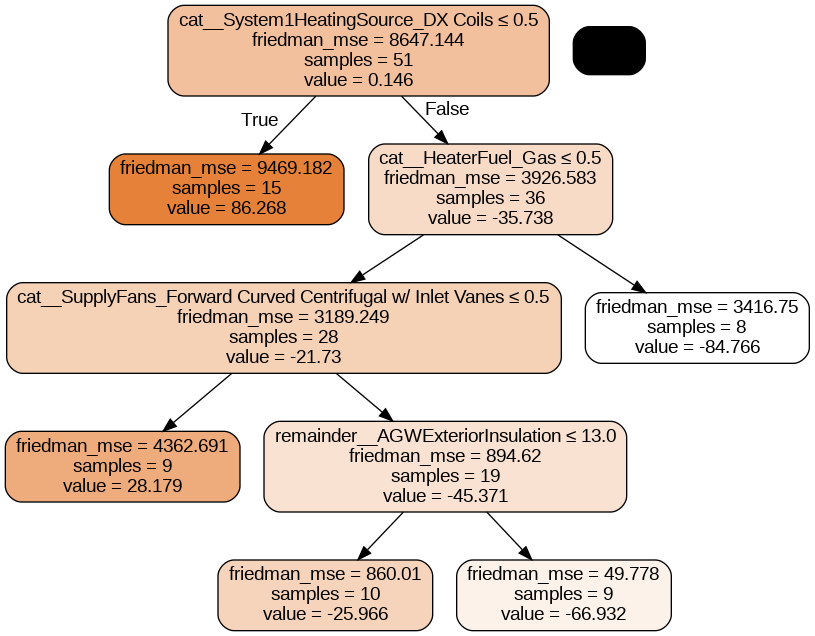

In [9]:


from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

# Access the first tree
first_tree = grb_HHP.estimators_[0, 0]

# Export and visualize the decision tree
dot_data = export_graphviz(
    first_tree,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    feature_names=encoded_HHP.columns.tolist()[:-1]   # Pass the one-hot encoded feature names
)

# Create a GraphViz graph from dot data
graph = graph_from_dot_data(dot_data)

# Convert the graph to PNG image
png = graph.create_png()

# Save (optional)
from pathlib import Path
Path('./out.png').write_bytes(png)

# Display
Image(png)



In [10]:
%pip install gurobipy
%pip install gurobipy_pandas
%pip install gurobi-machinelearning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 2.1 MB/s eta 0:00:00


In [11]:
from gurobi_ml import add_predictor_constr
import gurobipy as gp
import gurobipy_pandas as gppd

In [12]:
m = gp.Model("Green_budling_GB")

Restricted license - for non-production use only - expires 2025-11-24


In [13]:
# Add binary variables for the one-hot encoded columns
binary_columns = [col for col in encoded_HHP.columns if col.startswith('cat__')]
for column in binary_columns:
    m.addVar(vtype=gp.GRB.BINARY, name=column)

# Add continuous variables for the original numerical variables
# We use the prefix 'remainder__' to identify the original numerical columns
continuous_columns = [col for col in encoded_HHP[encoded_HHP.columns.tolist()[:-1]] if col.startswith('remainder__')]
for column in continuous_columns:
    # Extract the original column name (without 'remainder__' prefix)
    original_column_name = column.replace('remainder__', '')
    # Define bounds based on the min and max values of the original column
    lb = HHP[original_column_name].min()
    ub = HHP[original_column_name].max()
    # Add the variable to the model with the defined bounds
    m.addVar(lb=lb, ub=ub, vtype=gp.GRB.CONTINUOUS, name=column)

# Update the model to integrate the new variables
# Now, your model has the necessary decision variables defined as per your dataset.
m.update()

In [14]:
# Assuming m is your Gurobi model
variables_dict = {var.VarName: var for var in m.getVars()}
# Create a DataFrame with a single row containing the Gurobi variables
variables_df = pd.DataFrame(variables_dict, index=[0])

In [15]:
variables_df

,cat__RoofExtFinish_Aluminum Paint,cat__RoofExtFinish_Dark,cat__RoofExtFinish_Light,cat__RoofExtFinish_Uncolored,cat__AGWExtFinish_Dark,cat__AGWExtFinish_Light,cat__AGWExtFinish_Medium,cat__AGWExtFinish_Uncolored,cat__GlassCategory_Double Low E,cat__GlassCategory_Quadruple Low E,...,cat__HeaterType_instantaneous,remainder__RoofExteriorInsulation,remainder__RoofAddlInsulation,remainder__AGWExteriorInsulation,remainder__AGWInteriorInsulation,remainder__AGWAddlInsulation,remainder__CeilingsBattInsulation,remainder__VerticalWallsBattInsulation,remainder__GlassTypeThickness,remainder__GlassTypeSpacing
0,<gurobi.Var cat__RoofExtFinish_Aluminum Paint>,<gurobi.Var cat__RoofExtFinish_Dark>,<gurobi.Var cat__RoofExtFinish_Light>,<gurobi.Var cat__RoofExtFinish_Uncolored>,<gurobi.Var cat__AGWExtFinish_Dark>,<gurobi.Var cat__AGWExtFinish_Light>,<gurobi.Var cat__AGWExtFinish_Medium>,<gurobi.Var cat__AGWExtFinish_Uncolored>,<gurobi.Var cat__GlassCategory_Double Low E>,<gurobi.Var cat__GlassCategory_Quadruple Low E>,...,<gurobi.Var cat__HeaterType_instantaneous>,<gurobi.Var remainder__RoofExteriorInsulation>,<gurobi.Var remainder__RoofAddlInsulation>,<gurobi.Var remainder__AGWExteriorInsulation>,<gurobi.Var remainder__AGWInteriorInsulation>,<gurobi.Var remainder__AGWAddlInsulation>,<gurobi.Var remainder__CeilingsBattInsulation>,<gurobi.Var remainder__VerticalWallsBattInsula...,<gurobi.Var remainder__GlassTypeThickness>,<gurobi.Var remainder__GlassTypeSpacing>


In [16]:
HHP_approx = m.addVar(name="HHP_approx")
m.update

<bound method Model.update of <gurobi.Model MIP instance Green_budling_GB: 0 constrs, 38 vars, No parameter changes>>

In [17]:
m.setObjective(HHP_approx, gp.GRB.MINIMIZE)


In [18]:
print(encoded_HHP.columns.tolist()[:-1])

['cat__RoofExtFinish_Aluminum Paint', 'cat__RoofExtFinish_Dark', 'cat__RoofExtFinish_Light', 'cat__RoofExtFinish_Uncolored', 'cat__AGWExtFinish_Dark', 'cat__AGWExtFinish_Light', 'cat__AGWExtFinish_Medium', 'cat__AGWExtFinish_Uncolored', 'cat__GlassCategory_Double Low E', 'cat__GlassCategory_Quadruple Low E', 'cat__GlassCategory_Single Low E', 'cat__GlassCategory_Triple Low E', 'cat__GlassTypeEmissivity_High', 'cat__GlassTypeEmissivity_Low', 'cat__FrameType_AlumwBrkFixedMtlSpacer', 'cat__FrameType_FiberglassFixedMlt spacer', 'cat__FrameType_ReinforcedVinylFixedMtlSpacer', 'cat__FrameType_WoofFixedMltSpacer', 'cat__System1HeatingSource_DX Coils', 'cat__System1HeatingSource_Electric Resistance', 'cat__System1SystemType_Packaged VVT', 'cat__System1SystemType_Split System Single Zone', 'cat__SupplyFans_Forward Curved Centrifugal w/ Inlet Vanes', 'cat__SupplyFans_Two-Speed', 'cat__SupplyFans_Variable', 'cat__HeaterFuel_Electricity', 'cat__HeaterFuel_Gas', 'cat__HeaterType_Storage', 'cat__Hea

In [19]:
from gurobi_ml import add_predictor_constr

# Assuming gbr_model is your trained gradient boosting model
# And assuming feats is a list of feature names used by your model, which should match the column names in variables_df

# Use add_predictor_constr to add your model to the optimization problem
pred_constr = add_predictor_constr(m, grb_HHP, variables_df[encoded_HHP.columns.tolist()[:-1]], HHP_approx)

# Update the model to integrate the new constraints
m.update()

pred_constr.print_stats()

Model for gbtree_reg:
12 variables
3 constraints
38 general constraints
Input has shape (1, 38)
Output has shape (1, 1)

--------------------------------------------------------------------------------
Estimator       Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
tree                  (1, 1)            5            1            0           19

tree0                 (1, 1)            5            1            0           19

--------------------------------------------------------------------------------


In [20]:
# Assuming 'm' is your Gurobi model
for cat_var, one_hot_vars in one_hot_to_original_mapping.items():
    # Sum the binary variables corresponding to the one-hot encoded categories of each original feature
    # Ensure that this sum is >= 1, meaning at least one category must be selected
    m.addConstr(gp.quicksum(m.getVarByName(var) for var in one_hot_vars) == 1, name=f"select_at_least_one_{cat_var}")

# Update the model to integrate the new constraints
m.update()

In [21]:
m.write('boosted_tree_opt.lp')


In [22]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 13 rows, 51 columns and 42 nonzeros
Model fingerprint: 0xcb4a691c
Model has 38 general constraints
Variable types: 12 continuous, 39 integer (39 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 6e+01]
  RHS range        [1e+00, 6e+02]
  GenCon rhs range [3e-01, 1e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 2 rows and 0 columns
Presolve removed 0 rows and 31 columns
Presolve time: 0.00s
Presolved: 15 rows, 20 columns, 43 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 10 continuous, 10 integer (10 binary)
Found heuristic solution: objective 527.7566562
Found heuristic solution: objective 494.0912

In [23]:
# Variable info
varInfo = [(v.varName, v.X, v.LB, v.UB) for v in m.getVars() ]
df = pd.DataFrame(varInfo)
df.columns=['Variable Name','Solution Value', 'LB','UB']
df.to_excel("variables.xlsx", index=False)
df_var = df.query('`Solution Value` > 0')
df.to_csv('out.csv')
df_var

,Variable Name,Solution Value,LB,UB
0,cat__RoofExtFinish_Aluminum Paint,1.000000,0.000,1.00
4,cat__AGWExtFinish_Dark,1.000000,0.000,1.00
8,cat__GlassCategory_Double Low E,1.000000,0.000,1.00
12,cat__GlassTypeEmissivity_High,1.000000,0.000,1.00
14,cat__FrameType_AlumwBrkFixedMtlSpacer,1.000000,0.000,1.00
18,cat__System1HeatingSource_DX Coils,1.000000,0.000,1.00
20,cat__System1SystemType_Packaged VVT,1.000000,0.000,1.00
22,cat__SupplyFans_Forward Curved Centrifugal w/ ...,1.000000,0.000,1.00
26,cat__HeaterFuel_Gas,1.000000,0.000,1.00
27,cat__HeaterType_Storage,1.000000,0.000,1.00


In [24]:
m.dispose()

In [25]:
# Initialize dictionary to store second dataset feature values
optimal_design = {}
# Populate dictionary with feature names and values from second dataset
for feature, values in variables_df.items():
    optimal_design[feature] = 0

# Convert DataFrame to dictionary
df_dict = df_var.set_index('Variable Name')['Solution Value'].to_dict()


# Update values in your dictionary if there is a common key
for key in optimal_design.keys():
    if key in df_dict:
        optimal_design[key] = df_dict[key]

# Convert dictionary to DataFrame with one row and columns as variable names
optimal_design = pd.DataFrame(optimal_design, index=[0])

# print(optimal_design)
grb_HHP.predict(optimal_design)

array([494.09125625])